<a href="https://colab.research.google.com/github/RuwaAbey/Finaly_Year_Project_G09/blob/main/Zoom_transformer_in_NTU_RGB_action_class_58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [73]:
!pip install mmcv==1.5.0
!pip install fvcore

In [74]:
import mmcv
print(mmcv.__version__)

1.5.0


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
%cd /content/drive/My\ Drive/G_09

/content/drive/My Drive/G_09


In [77]:
!git clone https://github.com/kennymckormick/pyskl.git

fatal: destination path 'pyskl' already exists and is not an empty directory.


In [78]:
%cd /content/drive/My\ Drive/G_09/pyskl

/content/drive/My Drive/G_09/pyskl


In [79]:
import pyskl
import numpy as np

In [80]:
import pickle

%cd /content/drive/My\ Drive/G_09

# Load the pickle file
with open('ntu60_hrnet.pkl', 'rb') as f:
    data = pickle.load(f)

# Check the top-level keys
print(data.keys())  # Should print: ['split', 'annotations']

/content/drive/My Drive/G_09
dict_keys(['split', 'annotations'])


In [81]:
keypoint_pipeline = [
    dict(type='PoseDecode'),
    dict(type='PoseCompact', hw_ratio=1., allow_imgpad=True),
    dict(type='Resize', scale=(-1, 64)),
    dict(type='CenterCrop', crop_size=64),
    dict(type='GeneratePoseTarget', with_kp=True, with_limb=False)
]

limb_pipeline = [
    dict(type='PoseDecode'),
    dict(type='PoseCompact', hw_ratio=1., allow_imgpad=True),
    dict(type='Resize', scale=(-1, 64)),
    dict(type='CenterCrop', crop_size=64),
    dict(type='GeneratePoseTarget', with_kp=False, with_limb=True)
]

from pyskl.datasets.pipelines import Compose
def get_pseudo_heatmap(anno, flag='keypoint'):
    assert flag in ['keypoint', 'limb']
    pipeline = Compose(keypoint_pipeline if flag == 'keypoint' else limb_pipeline)
    return pipeline(anno)['imgs']

def vis_heatmaps(heatmaps, channel=-1, ratio=8):
    # if channel is -1, draw all keypoints / limbs on the same map
    import matplotlib.cm as cm
    heatmaps = [x.transpose(1, 2, 0) for x in heatmaps]
    h, w, _ = heatmaps[0].shape
    newh, neww = int(h * ratio), int(w * ratio)

    if channel == -1:
        heatmaps = [np.max(x, axis=-1) for x in heatmaps]
    cmap = cm.viridis
    heatmaps = [(cmap(x)[..., :3] * 255).astype(np.uint8) for x in heatmaps]
    heatmaps = [cv2.resize(x, (neww, newh)) for x in heatmaps]
    return heatmaps

In [97]:
# Extract the annotations field
annotations = data['annotations']

for annotation in annotations:
    if annotation['frame_dir'] == 'S001C001P001R001A059':
        action_58_sample = annotation
        print(annotation)


{'frame_dir': 'S001C001P001R001A059', 'label': 58, 'img_shape': (1080, 1920), 'original_shape': (1080, 1920), 'total_frames': 99, 'keypoint': array([[[[1433. ,  321. ],
         [1441. ,  312.5],
         [1429. ,  312.5],
         ...,
         [1425. ,  588.5],
         [1450. ,  676. ],
         [1425. ,  668. ]],

        [[1431. ,  323.2],
         [1439. ,  315. ],
         [1431. ,  315. ],
         ...,
         [1427. ,  588. ],
         [1448. ,  676. ],
         [1423. ,  667.5]],

        [[1433. ,  321. ],
         [1441. ,  312.5],
         [1429. ,  312.5],
         ...,
         [1425. ,  588.5],
         [1445. ,  676. ],
         [1425. ,  668. ]],

        ...,

        [[ 872. ,  323.5],
         [ 867.5,  310.8],
         [ 863.5,  310.8],
         ...,
         [ 855. ,  601.5],
         [ 859. ,  678.5],
         [ 850.5,  691.5]],

        [[ 873. ,  323.2],
         [ 868.5,  310.5],
         [ 864.5,  314.8],
         ...,
         [ 856. ,  600. ],
         [

In [98]:
action_58_sample_keypoint = action_58_sample['keypoint']
#action_58_sample_keypoint

In [99]:
action_58_sample_keypoint_score = action_58_sample['keypoint_score']
#action_58_sample_keypoint_score

In [100]:
import numpy as np

coordinates = action_58_sample_keypoint
confidence_scores = action_58_sample_keypoint_score

# Assuming these are your original arrays
coords = coordinates  # Replace with actual data
conf = confidence_scores       # Replace with actual data

# Transpose coordinates to (M, C, T, V)
coords = np.transpose(coords, (0, 3, 1, 2))  # Shape: (2, 2, 99, 17)

# Expand confidence scores to match dimensions (M, 1, T, V)
conf = np.expand_dims(conf, axis=1)  # Shape: (2, 1, 99, 17)

# Concatenate along the second axis (C)
combined = np.concatenate((coords, conf), axis=1)  # Shape: (2, 3, 99, 17)

# Swap M and last dimension (M should be last)
combined = np.transpose(combined, (1, 2, 3, 0))  # Shape: (3, 99, 17, 2)

# Add batch dimension (N=1)
final_array = np.expand_dims(combined, axis=0)  # Shape: (1, 3, 99, 17, 2)

print(final_array.shape)  # Expected Output: (1, 3, 99, 17, 2)
print(final_array)

x = final_array
x.shape

(1, 3, 99, 17, 2)
[[[[[1.4330e+03 4.7125e+02]
    [1.4410e+03 4.7125e+02]
    [1.4290e+03 4.5825e+02]
    ...
    [1.4250e+03 4.6675e+02]
    [1.4500e+03 4.8825e+02]
    [1.4250e+03 4.7125e+02]]

   [[1.4310e+03 4.6925e+02]
    [1.4390e+03 4.7350e+02]
    [1.4310e+03 4.5625e+02]
    ...
    [1.4270e+03 4.6475e+02]
    [1.4480e+03 4.9050e+02]
    [1.4230e+03 4.7350e+02]]

   [[1.4330e+03 4.6925e+02]
    [1.4410e+03 4.7350e+02]
    [1.4290e+03 4.5625e+02]
    ...
    [1.4250e+03 4.6475e+02]
    [1.4450e+03 4.9050e+02]
    [1.4250e+03 4.7350e+02]]

   ...

   [[8.7200e+02 1.0090e+03]
    [8.6750e+02 1.0135e+03]
    [8.6350e+02 1.0090e+03]
    ...
    [8.5500e+02 1.0450e+03]
    [8.5900e+02 1.0490e+03]
    [8.5050e+02 1.0580e+03]]

   [[8.7300e+02 1.0070e+03]
    [8.6850e+02 1.0115e+03]
    [8.6450e+02 1.0070e+03]
    ...
    [8.5600e+02 1.0470e+03]
    [8.5600e+02 1.0510e+03]
    [8.5150e+02 1.0560e+03]]

   [[1.0050e+03 8.7400e+02]
    [1.0140e+03 8.6950e+02]
    [1.0095e+03 8.6100e+02]


(1, 3, 99, 17, 2)

In [101]:
x = torch.tensor(x).float() # Convert NumPy array to PyTorch tensor
#print(x.size())  # Now this should work

In [87]:
import math
from einops import rearrange
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


def import_class(name):
    components = name.split('.')
    mod = __import__(components[0])
    for comp in components[1:]:
        mod = getattr(mod, comp)
    return mod


def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)


def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)


def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()

        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                                stride=(stride, 1))

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        conv_init(self.conv)
        bn_init(self.bn, 1)

    def forward(self, x):
        x = self.bn(self.conv(x))
        return x


class unit_tcn_m(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=[1, 3, 7]):        # ks=9 initial
        super(unit_tcn_m, self).__init__()

        pad1 = int((kernel_size[0] - 1) / 2)
        pad2 = int((kernel_size[1] - 1) / 2)
        pad3 = int((kernel_size[2] - 1) / 2)

        mid_channels = out_channels//3

        self.conv11 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))
        self.conv21 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))
        self.conv31 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))

        self.conv12 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[0], 1), padding=(pad1, 0),
                                stride=(stride, 1))
        self.conv22 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[1], 1), padding=(pad2, 0),
                                stride=(stride, 1))
        self.conv32 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[2], 1), padding=(pad3, 0),
                                stride=(stride, 1))

        self.bn = nn.BatchNorm2d(out_channels)
        conv_init(self.conv11)
        conv_init(self.conv21)
        conv_init(self.conv31)
        conv_init(self.conv12)
        conv_init(self.conv22)
        conv_init(self.conv32)
        bn_init(self.bn, 1)

    def forward(self, x):
        x1 = self.conv12(self.conv11(x))
        x2 = self.conv22(self.conv21(x))
        x3 = self.conv32(self.conv31(x))
        x = torch.cat([x1, x2, x3], dim=1)
        x  = self.bn(x)
        return x




class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = Variable(torch.from_numpy(A.astype(np.float32)), requires_grad=False)
        self.num_subset = num_subset

        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))

        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x

        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU()

    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA

        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            #print(f"A1 shape {i}: {A1.shape}")
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            #print(f"A2 shape {i}: {A2.shape}")
            A1 = self.soft(torch.matmul(A1, A2) / A1.size(-1))  # N V V
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z

        y = self.bn(y)
        y += self.down(x)
       # print(f"y shape: {y.shape}")
        return self.relu(y)




class TCN_GCN_unit(nn.Module):

    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn_m(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU()
        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP_Block(nn.Module):
    def __init__(self, dim, hid_dim, dropout = 0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hid_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        self.af1 = nn.ReLU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hid_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std = 1e-6)
        self.do2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)

        return x

class Attention(nn.Module):
    def __init__(self, dim, out_dim, heads = 3, dropout = 0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5  # 1/sqrt(dim)

        self.to_qkv = nn.Linear(dim, dim*3, bias = True)
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)

        self.nn1 = nn.Linear(dim, out_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)
        self.do1 = nn.Dropout(dropout)


    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x) #gets q = Q = Wq matmul x1, k = Wk mm x2, v = Wv mm x3
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv = 3, h = h) # split into multi head attentions

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        attn = dots.softmax(dim=-1) #follow the softmax,q,d,v equation in the paper

        if mask is not None:
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            dots = (dots + mask)*0.5

        out = torch.einsum('bhij,bhjd->bhid', attn, v) #product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)') #concat heads into one matrix, ready for next encoder block
        out =  self.nn1(out)
        out = self.do1(out)

        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        if dim == mlp_dim:
            for _ in range(depth):
                self.layers.append(nn.ModuleList([
                    Residual(Attention(dim, mlp_dim, heads = heads, dropout = dropout)),
                    Residual(LayerNormalize(mlp_dim, MLP_Block(mlp_dim, mlp_dim*2, dropout = dropout)))
                ]))
        else:
            for _ in range(depth):
                self.layers.append(nn.ModuleList([
                    Attention(dim, mlp_dim, heads = heads, dropout = dropout),
                    Residual(LayerNormalize(mlp_dim, MLP_Block(mlp_dim, mlp_dim*2, dropout = dropout)))
                ]))
    def forward(self, x, mask = None):
        for attention, mlp in self.layers:
            x = attention(x, mask = mask) # go to attention
            x = mlp(x) #go to MLP_Block
        return x



class TCN_STRANSF_unit(nn.Module):
    def __init__(self, in_channels, out_channels, heads=3, stride=1, residual=True, dropout=0.1, mask=None, mask_grad=True):
        super(TCN_STRANSF_unit, self).__init__()
        self.transf1 = Transformer(dim=in_channels, depth=1, heads=heads, mlp_dim=in_channels, dropout=dropout)
        self.tcn1 = unit_tcn_m(in_channels, out_channels, stride=stride)
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)

        if mask != None:
            self.mask = nn.Parameter(mask, requires_grad=mask_grad)

    def forward(self, x, mask=None):
        B, C, T, V= x.size()
        tx = x.permute(0, 2, 3, 1).contiguous().view(B * T, V, C)
        if mask==None:
            tx = self.transf1(tx, self.mask)
        else:
            tx = self.transf1(tx, mask)
        tx = tx.view(B, T, V, C).permute(0, 3, 1, 2).contiguous()

        x = self.tcn1(tx) + self.residual(x)
        return self.relu(x)






In [88]:
num_class=15
in_channels=3
num_person=2
num_point=17
num_head=6
data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
bn_init(data_bn, 1)
heads = num_head

In [102]:
N, C, T, V, M = x.size()
x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
x = data_bn(x)
x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)

In [103]:
num_node = 17 #coco keypoints
self_link = [(i, i) for i in range(num_node)]
inward = [
    (10, 8), (8, 6), (9, 7), (7, 5),  # Arms: Wrist → Elbow → Shoulder
    (15, 13), (13, 11), (16, 14), (14, 12),  # Legs: Ankle → Knee → Hip
    (11, 5), (12, 6), (11, 12), (5, 6),  # Torso: Hips ↔ Shoulders
    (5, 0), (6, 0), (1, 0), (2, 0), (3, 1), (4, 2)  # Face: Nose → Eyes → Ears
]
outward = [(j, i) for (i, j) in inward]  # Reverse edges
A = np.zeros((num_node, num_node))
def edge2mat(link, num_node):
    """ Convert edge list to adjacency matrix """
    A = np.zeros((num_node, num_node))  # Initialize a zero matrix
    for i, j in link:
        A[j, i] = 1  # Assign 1 to the adjacency matrix
    return A

#Compute Self-Link Adjacency Matrix
I = edge2mat(self_link, num_node)
# Compute Inward Adjacency Matrix (In)
In = edge2mat(inward, num_node)
# Compute Outward Adjacency Matrix (Out)
Out = edge2mat(outward, num_node)
A = np.stack((I, In, Out))
A

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.

In [104]:
import math
from einops import rearrange
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


def import_class(name):
    components = name.split('.')
    mod = __import__(components[0])
    for comp in components[1:]:
        mod = getattr(mod, comp)
    return mod


def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)


def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)


def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()

        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                                stride=(stride, 1))

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        conv_init(self.conv)
        bn_init(self.bn, 1)

    def forward(self, x):
        x = self.bn(self.conv(x))
        return x


class unit_tcn_m(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=[1, 3, 7]):        # ks=9 initial
        super(unit_tcn_m, self).__init__()

        pad1 = int((kernel_size[0] - 1) / 2)
        pad2 = int((kernel_size[1] - 1) / 2)
        pad3 = int((kernel_size[2] - 1) / 2)

        mid_channels = out_channels//3

        self.conv11 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))
        self.conv21 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))
        self.conv31 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 1))

        self.conv12 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[0], 1), padding=(pad1, 0),
                                stride=(stride, 1))
        self.conv22 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[1], 1), padding=(pad2, 0),
                                stride=(stride, 1))
        self.conv32 = nn.Conv2d(in_channels, mid_channels, kernel_size=(kernel_size[2], 1), padding=(pad3, 0),
                                stride=(stride, 1))

        self.bn = nn.BatchNorm2d(out_channels)
        conv_init(self.conv11)
        conv_init(self.conv21)
        conv_init(self.conv31)
        conv_init(self.conv12)
        conv_init(self.conv22)
        conv_init(self.conv32)
        bn_init(self.bn, 1)

    def forward(self, x):
        x1 = self.conv12(self.conv11(x))
        x2 = self.conv22(self.conv21(x))
        x3 = self.conv32(self.conv31(x))
        x = torch.cat([x1, x2, x3], dim=1)
        x  = self.bn(x)
        return x




class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = Variable(torch.from_numpy(A.astype(np.float32)), requires_grad=False)
        self.num_subset = num_subset

        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))

        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x

        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU()

    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA

        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            #print(f"A1 shape {i}: {A1.shape}")
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            #print(f"A2 shape {i}: {A2.shape}")
            A1 = self.soft(torch.matmul(A1, A2) / A1.size(-1))  # N V V
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z

        y = self.bn(y)
        y += self.down(x)
       # print(f"y shape: {y.shape}")
        return self.relu(y)




class TCN_GCN_unit(nn.Module):

    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn_m(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU()
        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP_Block(nn.Module):
    def __init__(self, dim, hid_dim, dropout = 0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hid_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        self.af1 = nn.ReLU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hid_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std = 1e-6)
        self.do2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)

        return x

class Attention(nn.Module):
    def __init__(self, dim, out_dim, heads = 3, dropout = 0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5  # 1/sqrt(dim)

        self.to_qkv = nn.Linear(dim, dim*3, bias = True)
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)

        self.nn1 = nn.Linear(dim, out_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)
        self.do1 = nn.Dropout(dropout)


    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x) #gets q = Q = Wq matmul x1, k = Wk mm x2, v = Wv mm x3
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv = 3, h = h) # split into multi head attentions

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        attn = dots.softmax(dim=-1) #follow the softmax,q,d,v equation in the paper

        if mask is not None:
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            dots = (dots + mask)*0.5

        out = torch.einsum('bhij,bhjd->bhid', attn, v) #product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)') #concat heads into one matrix, ready for next encoder block
        out =  self.nn1(out)
        out = self.do1(out)

        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        if dim == mlp_dim:
            for _ in range(depth):
                self.layers.append(nn.ModuleList([
                    Residual(Attention(dim, mlp_dim, heads = heads, dropout = dropout)),
                    Residual(LayerNormalize(mlp_dim, MLP_Block(mlp_dim, mlp_dim*2, dropout = dropout)))
                ]))
        else:
            for _ in range(depth):
                self.layers.append(nn.ModuleList([
                    Attention(dim, mlp_dim, heads = heads, dropout = dropout),
                    Residual(LayerNormalize(mlp_dim, MLP_Block(mlp_dim, mlp_dim*2, dropout = dropout)))
                ]))
    def forward(self, x, mask = None):
        for attention, mlp in self.layers:
            x = attention(x, mask = mask) # go to attention
            x = mlp(x) #go to MLP_Block
        return x



class TCN_STRANSF_unit(nn.Module):
    def __init__(self, in_channels, out_channels, heads=3, stride=1, residual=True, dropout=0.1, mask=None, mask_grad=True):
        super(TCN_STRANSF_unit, self).__init__()
        self.transf1 = Transformer(dim=in_channels, depth=1, heads=heads, mlp_dim=in_channels, dropout=dropout)
        self.tcn1 = unit_tcn_m(in_channels, out_channels, stride=stride)
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)

        if mask != None:
            self.mask = nn.Parameter(mask, requires_grad=mask_grad)

    def forward(self, x, mask=None):
        B, C, T, V= x.size()
        tx = x.permute(0, 2, 3, 1).contiguous().view(B * T, V, C)
        if mask==None:
            tx = self.transf1(tx, self.mask)
        else:
            tx = self.transf1(tx, mask)
        tx = tx.view(B, T, V, C).permute(0, 3, 1, 2).contiguous()

        x = self.tcn1(tx) + self.residual(x)
        return self.relu(x)






In [105]:
l1 = TCN_GCN_unit(3, 48, A, residual=False)
output_layer_1 = l1(x)

In [106]:
x.size()

torch.Size([2, 3, 99, 17])

In [107]:
output_layer_1.size()

torch.Size([2, 48, 99, 17])

In [113]:

A_0 = torch.from_numpy(A[0].astype(np.float32))
l1 = TCN_GCN_unit(3, 48, A, residual=False)
l2 = TCN_STRANSF_unit(48, 48, heads=num_head, mask=A_0, mask_grad=False)
l3 = TCN_STRANSF_unit(48, 48, heads=num_head, mask=A_0, mask_grad=False)
l4 = TCN_STRANSF_unit(48, 96, heads=num_head, stride=2, mask=A_0, mask_grad=True)
l5 = TCN_STRANSF_unit(96, 96, heads=num_head, mask=A_0, mask_grad=True)
l6 = TCN_STRANSF_unit(96, 192, heads=num_head, stride=2, mask=A_0, mask_grad=True)
l7 = TCN_STRANSF_unit(192, 192, heads=num_head, mask=A_0, mask_grad=True)

In [114]:
output_layer_1 = l1(x)
output_layer_2 = l2(output_layer_1)
output_layer_3 = l3(output_layer_2)
output_layer_4 = l4(output_layer_3)
output_layer_5 = l5(output_layer_4)
output_layer_6 = l6(output_layer_5)
output_layer_7 = l7(output_layer_6)

In [116]:
output_layer_7.size()

torch.Size([2, 192, 25, 17])

In [119]:
B, C_, T_, V_ = output_layer_7.size()
output_ZiT = output_layer_7.view(N, M, C_, T_, V_).mean(4)
output_ZiT = output_ZiT.permute(0, 2, 3, 1).contiguous()

In [120]:
output_ZiT.size()

torch.Size([1, 192, 25, 2])

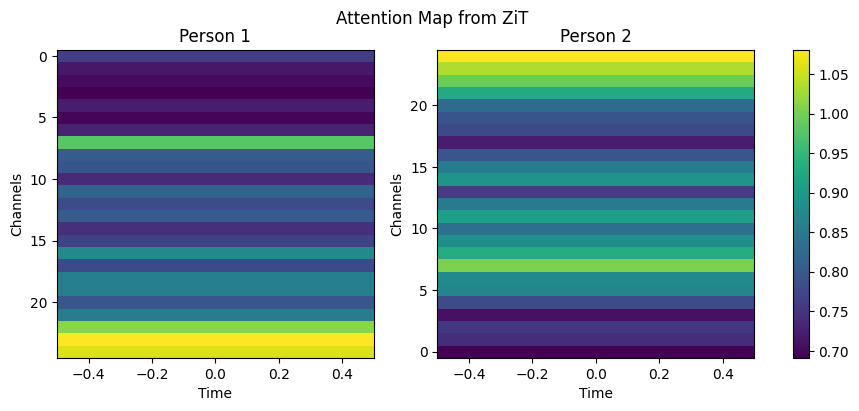

In [125]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example output tensor from ZiT (Replace with actual tensor)
#ZiT_output = torch.rand(1, 192, 25, 2)  # Shape: [1, 192, 25, 2]


# Remove batch dimension
feature_map = output_ZiT[0]  # Shape: [192, 25, 2]

# Compute attention scores by averaging over channels
attention_map = feature_map.mean(dim=0)  # Shape: [25, 2] (Time frames × Persons)

# Convert to NumPy for visualization
attention_map_np = attention_map.detach().cpu().numpy()

# Plot the heatmap for each person separately
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):  # Loop over persons
    axes[i].imshow(attention_map_np[:, i].reshape(25, 1), cmap='viridis', aspect='auto')
    axes[i].set_title(f"Person {i+1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Channels")
    axes[i].invert_yaxis()  # To match the paper's view

plt.colorbar(axes[0].imshow(attention_map_np[:, 0].reshape(25, 1), cmap='viridis', aspect='auto'),
             ax=axes, orientation='vertical', fraction=0.05)
plt.suptitle("Attention Map from ZiT")
plt.show()
